<a id="top"></a>
# UN SDG Indicator 11.3.1:<br> Ratio of Land Consumption Rate to Population Growth Rate


<hr>

# Notebook Summary
The United Nations have prescribed 17 "Sustainable Development Goals" (SDGs). This notebook attempts to monitor SDG Indicator 11.3.1 - ratio of land consumption rate to population growth rate.

UN SDG Indicator 11.3.1 provides a metric for determining wether or not land consumption is scaling responsibly with the growth of the  population in a given region.  

### Case Study

This notebook conducts analysis in the **Dar es Salaam, Tanzania** with reference years of `2000` and `2015`.

# Index

* [Define Formulas for Calculating the Indicator](#define_formulas)
* [Import Dependencies and Connect to the Data Cube](#import)
* [Show the Area](#show_area)
* [Determine Population Growth Rate](#pop_rate)
* [Determine Land Consumption Rate](#land_consumption_rate)
* [Build Composites for the First and Last Years](#false_color_composites)
* [Filter Out Everything Except the Survey Region](#filter_survey_region)
* [Determine Urban Extent](#urban_extent)
* [SDG Indicator 11.3.1](#indicator)

## <a id="define_formulas"></a>Define Formulas for Calculating the Indicator [&#9652;](#top)


>### SDG Indicator 11.3.1
> The ratio between land consumption and population growth rate.   

$$ SDG_{11.1.3} = \frac{LandConsumptionRate}{PopulationGrowthRate} $$

In [1]:
def sdg_11_3_1(land_consumption, population_growth_rate): 
    return land_consumption/population_growth_rate


>### Population Growth rate

### $$ PopulationGrowthRate = 10 ^ {LOG( Pop_{t_2} \space / \space Pop_{t_1}) \space / \space {y}} - 1 $$
  
Where:  

- $Pop_{t_2}$ - Total population within the area in the current/final year
- $Pop_{t_1}$ - Total population within the area in the past/initial year  
- $y$   - The number of years between the two measurement periods $t = Year_{t_2} - Year_{t_1}$ 

In [2]:
import numpy as np  

def population_growth_rate(pop_t1 = None, pop_t2 = None, y = None): 
#     return np.log(pop_t2/pop_t1)/y
    return 10**(np.log10(pop_t2/pop_t1)/y) - 1


>### Land Consumption Rate


### $$ LandConsumptionRate = 10 ^ {LOG( Area_{t_2} \space / \space Area_{t_1}) \space / \space {y}} - 1 $$

Where:  

- $Area_{t_2}$ - Total area considered to be *urbanized* in the current/final year
- $Area_{t_1}$ - Total area considered to be *urbanized* in the past/initial year  
- $y$   - The number of years between the two measurement periods $t = Year_{t_2} - Year_{t_1}$ 

In [3]:
def land_consumption_rate(area_t1 = None, area_t2 = None, y = None):
#     return np.log(area_t2 / area_t1)/y
    return 10**(np.log10(area_t2/area_t1)/y) - 1

## <a id="import"></a>Import Dependencies and Connect to the Data Cube [&#9652;](#top)

In [4]:
# Supress Some Warnings
import warnings
warnings.filterwarnings('ignore')
# Allow importing of our utilities.
import sys
sys.path.append("..")
# Prepare for plotting.
import matplotlib.pyplot as plt
%matplotlib inline

import datacube
dc = datacube.Datacube()

## <a id="show_area"></a>Show the Area [&#9652;](#top)

In [5]:
# Dar es Salaam, Tanzania
latitude_extents =  (-6.95, -6.70) 
longitude_extents =  (39.05, 39.45)

In [6]:
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude = latitude_extents, longitude = longitude_extents)

## <a id="pop_rate"></a>Determine Population Growth Rate [&#9652;](#top)

>### Load Population Data
<br>Shape files are based on GPW estimates. You can derive similar population figures from AidData GeoQuery at 
- http://geo.aiddata.org/query

In [7]:
CSV_FILE_PATH = "data/Tanzania/population_shape/ADM2_GPWV4_population.csv"
SHAPE_FILE_PATH = "data/Tanzania/population_shape/TZA_ADM2.geojson"

In [8]:
import geopandas as gpd
import pandas as pd

first_year, last_year = 2000, 2015
first_year_pop_col = 'gpw_v4_count.{}.sum'.format(first_year)
last_year_pop_col = 'gpw_v4_count.{}.sum'.format(last_year)

shape_data = gpd.read_file(SHAPE_FILE_PATH)
shape_data = shape_data[['Name', 'geometry']]
pop_data = pd.read_csv(CSV_FILE_PATH)
pop_data = pop_data[[first_year_pop_col, last_year_pop_col, 'Name']]
pop_data = pop_data.rename({first_year_pop_col: 'pop_t1', 
                            last_year_pop_col: 'pop_t2'}, axis='columns')
country_data = shape_data.merge(pop_data, on='Name')

In [9]:
def shapely_geom_intersects_rect(geom, x, y):
    """
    Determines whether the bounding box of a Shapely polygon intesects 
    a rectangle defined by `x` and `y` extents.
    
    Parameters
    ----------
    geom: shapely.geometry.polygon.Polygon
        The object to determine intersection with the region defined by `x` and `y`.
    x, y: list-like
        The x and y extents, expressed as 2-tuples.
        
    Returns
    -------
    intersects: bool
        Whether the bounding box of `geom` intersects the rectangle.
    """
    geom_bounds = np.array(list(geom.bounds))
    x_shp, y_shp = geom_bounds[[0,2]], geom_bounds[[1,3]]
    x_in_range = (x_shp[0] < x[1]) & (x[0] < x_shp[1])
    y_in_range = (y_shp[0] < y[1]) & (y[0] < y_shp[1])
    return x_in_range & y_in_range
    
intersecting_shapes = country_data[country_data.apply(
    lambda row: shapely_geom_intersects_rect(row.geometry, longitude_extents, latitude_extents), 
    axis=1).values]

**Show the Survey Region in the Context of the Country**

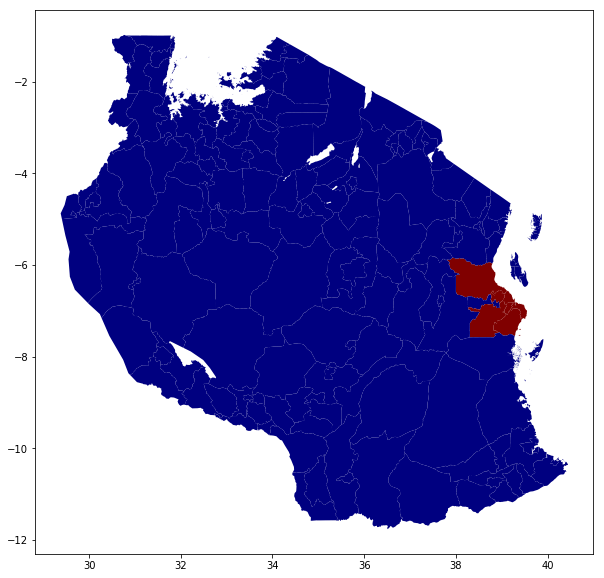

In [10]:
country_data.plot(column=country_data.Name.isin(intersecting_shapes['Name']), 
                                                    cmap='jet', figsize=(10,10))
survey_region = country_data[country_data.Name.isin(['Kinondoni', 'Ilala', 'Temeke'])]
plt.show()

**Show the Survey Region Alone**

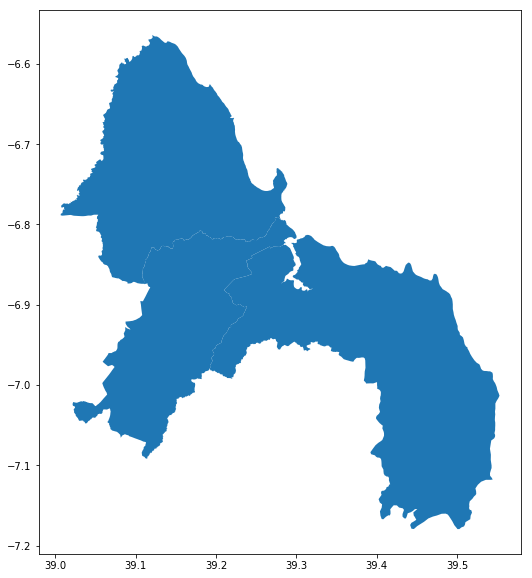

In [11]:
survey_region.plot( figsize = (10,10))
plt.show()

**Determine the Shape that Masks the Survey Region**

In [12]:
from shapely.ops import cascaded_union
disjoint_areas = cascaded_union([*survey_region.geometry]) ## Top Right is 'disjoint' from bottom left.  

>### Calculate Population Growth Rate

**Calcuate Population Growth Rate for All Regions Individually**

In [13]:
country_data = country_data.assign(population_growth_rate = 
                                   np.log(country_data["pop_t2"]/country_data["pop_t1"])/10)

**Visualize Population Growth Rate**

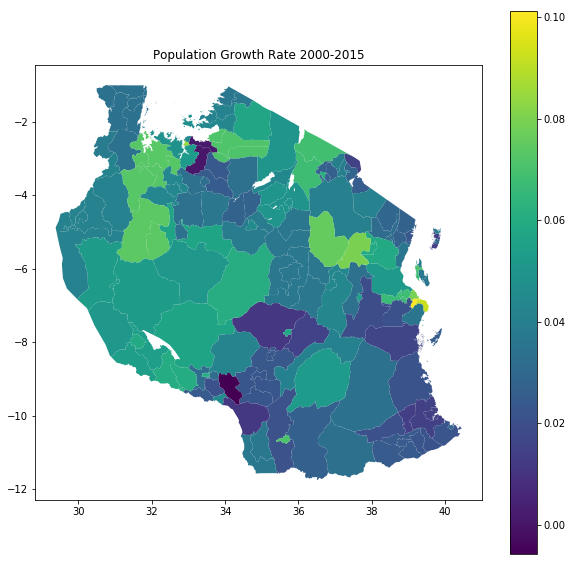

In [14]:
fig, ax = plt.subplots(figsize  = (10, 10))
ax.set_title("Population Growth Rate {}-{}".format(first_year, last_year))
ax1 = country_data.plot(column = "population_growth_rate", ax = ax, legend=True)

In [15]:
survey_region_total_pop_t1 = survey_region["pop_t1"].sum()
survey_region_total_pop_t2 = survey_region["pop_t2"].sum()

In [16]:
time_range = last_year - first_year
pop_growth = population_growth_rate(pop_t1 = survey_region_total_pop_t1,
                                    pop_t2 = survey_region_total_pop_t2,
                                    y = time_range)

In [17]:
print("Population Growth Rate of the Survey Region: {:.2%}".format(pop_growth))

Population Growth Rate of the Survey Region: 6.16%



## <a id="land_consumption_rate"></a>Determine Land Consumption Rate [&#9652;](#top)

**Load Landsat Imagery**

In [18]:
product = "ls7_ledaps_tanzania" 
platform = "LANDSAT_7"
measurements =  ["red", "green", "blue", "nir", "swir1", "swir2", "pixel_qa"]
EPSG = "EPSG:4326"

In [19]:
# Determine the bounding box of the survey region to load data for.
min_lon, min_lat, max_lon, max_lat = disjoint_areas.bounds
lat = (min_lat, max_lat)
lon = (min_lon, max_lon)

In [20]:
time_extents_t1 = ('2000-01-01', '2000-12-31')
time_extents_t2 = ('2015-01-01', '2015-12-31')

In [21]:
load_params = dict(product = product, measurements = measurements, 
                   latitude = lat, longitude = lon)

In [22]:
dataset_t1 =  dc.load(**load_params, time=time_extents_t1)
dataset_t2 =  dc.load(**load_params, time=time_extents_t2)

## <a id="false_color_composites"></a>Build Composites for the First and Last Years [&#9652;](#top)

In [23]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
from utils.data_cube_utilities.dc_mosaic import create_median_mosaic

In [24]:
clean_mask_t1 = landsat_qa_clean_mask(dataset_t1, platform)
clean_mask_t2 = landsat_qa_clean_mask(dataset_t2, platform)

composite_t1 = create_median_mosaic(dataset_t1, clean_mask_t1)
composite_t2 = create_median_mosaic(dataset_t2, clean_mask_t2)

> ### **First Year**
> False Color Composite [nir, swir1, blue]

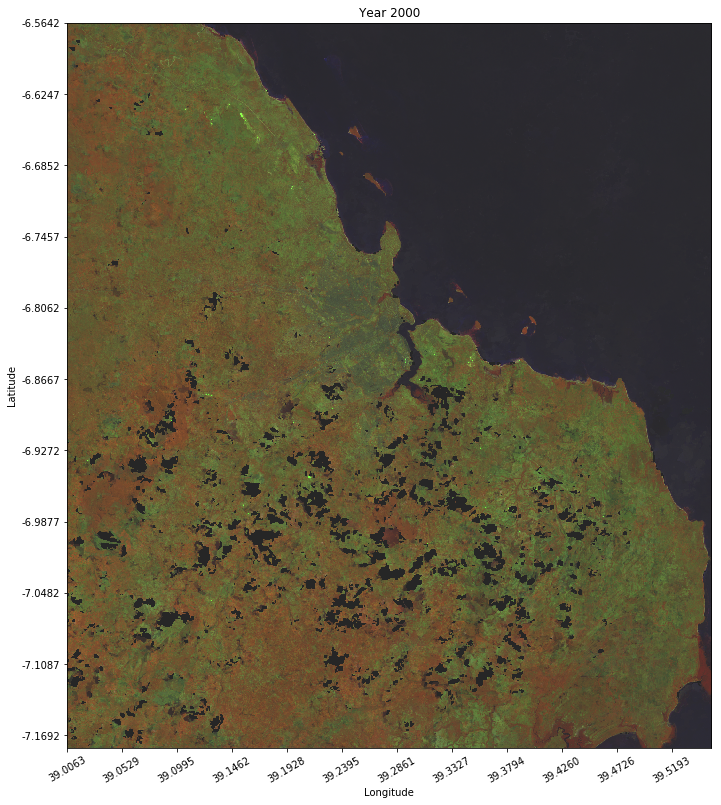

In [25]:
from utils.data_cube_utilities.dc_rgb import rgb
rgb(composite_t1, bands = ["nir","swir1","blue"], width = 15)
plt.title('Year {}'.format(first_year))
plt.show()

> ### Last Year
> False Color Composite [nir, swir1, blue]

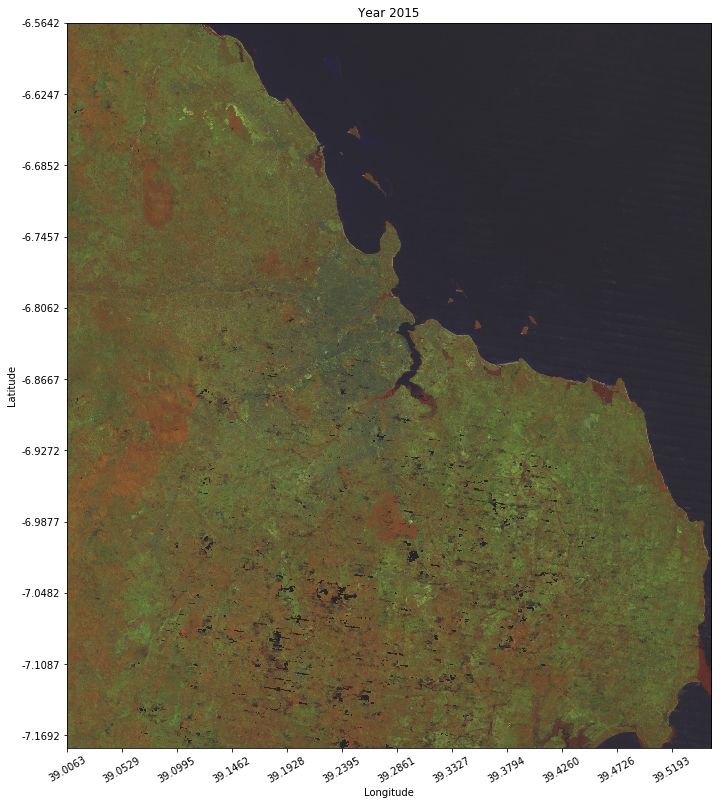

In [26]:
rgb(composite_t2, bands = ["nir","swir1","blue"], width = 15)
plt.title('Year {}'.format(last_year))
plt.show()

## <a id="filter_survey_region"></a>Filter Out Everything Except the Survey Region [&#9652;](#top)

In [27]:
import rasterio.features
from datacube.utils import geometry
import xarray as xr

def generate_mask(loaded_dataset:xr.Dataset,
                  geo_polygon: datacube.utils.geometry ):
    
    return rasterio.features.geometry_mask(
                                [geo_polygon],
                                out_shape = loaded_dataset.geobox.shape,
                                transform = loaded_dataset.geobox.affine,
                                all_touched = False,
                                invert = True)

In [28]:
mask = generate_mask(dataset_t1, disjoint_areas)

In [29]:
filtered_composite_t1 = composite_t1.where(mask)
filtered_composite_t2 = composite_t2.where(mask)

> ### **First Year Survey Region**
> False Color Composite [nir, swir1, blue]

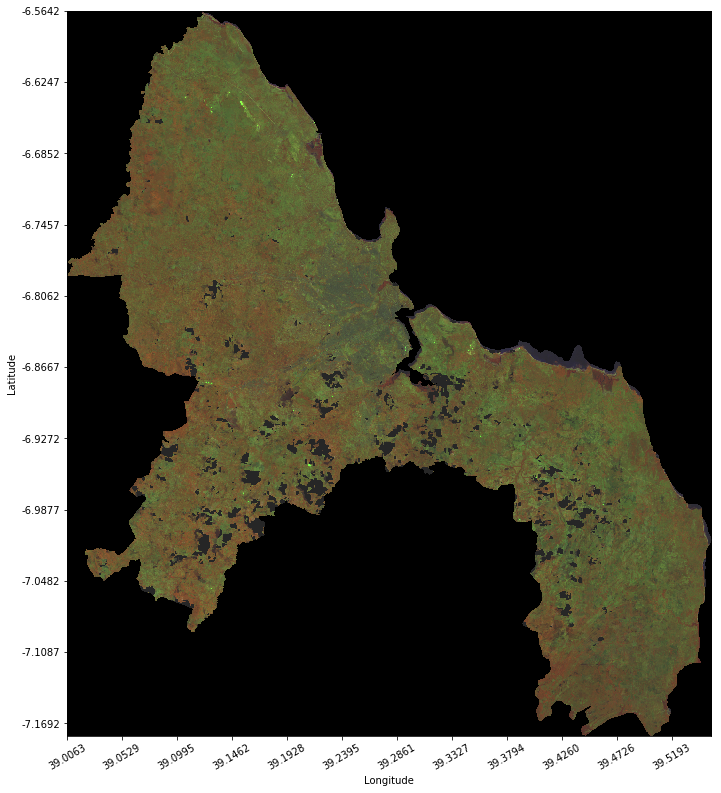

In [30]:
rgb(filtered_composite_t1, bands = ["nir","swir1","blue"],width = 15)
plt.show()

> ### **Last Year Survey Region**
> False Color Composite [nir, swir1, blue]

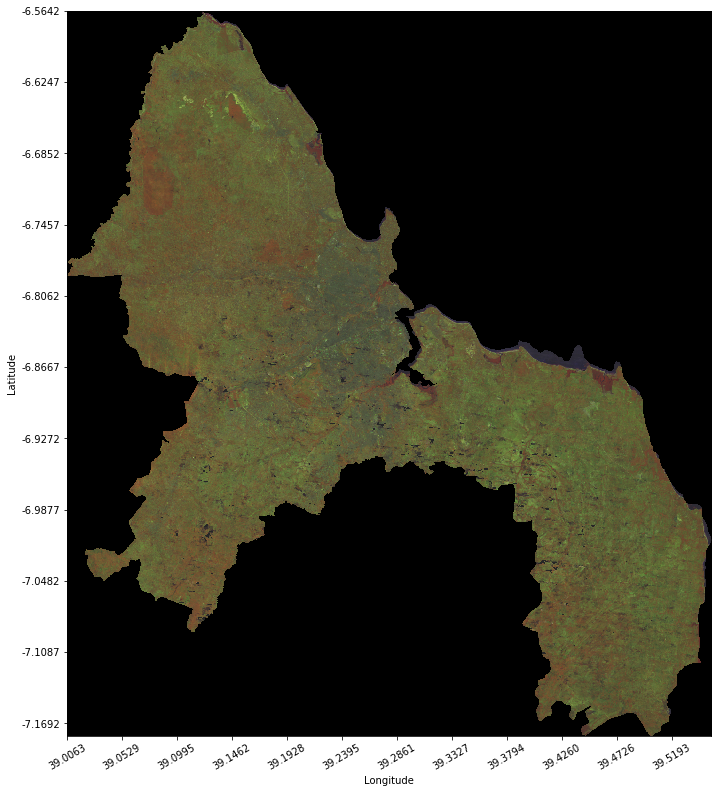

In [31]:
rgb(filtered_composite_t2, bands = ["nir","swir1","blue"],width = 15)
plt.show()

## <a id="urban_extent"></a>Determine Urban Extent [&#9652;](#top)

> ### Urbanization Index Option 1: NDBI  
> The Normalized Difference Built-up Index (NDBI) is quick to calculate, but is sometimes inaccurate (e.g. in very arid regions).

In [32]:
def NDBI(dataset):
    return (dataset.swir1 - dataset.nir)/(dataset.swir1 + dataset.nir)

> ### Urbanization Index Option 2: Fractional Cover Bare Soil
> The fractional cover bare soil index is very slow to calculate in its current implementation, but is often more accurate than NDBI.

In [33]:
from utils.data_cube_utilities.dc_fractional_coverage_classifier import frac_coverage_classify

**Choose the Urbanization Index to Use**

In [34]:
# Can be 'NDBI' or 'Fractional Cover'.
urbanization_index = 'Fractional Cover Bare Soil'

In [35]:
urban_index_func = None
urban_index_range = None
if urbanization_index == 'NDBI':
    urban_index_func = NDBI
    urban_index_range = [-1, 1]
if urbanization_index == 'Fractional Cover Bare Soil':
    urban_index_func = lambda dataset: frac_coverage_classify(dataset).bs
    urban_index_range = [0, 100]    
plot_kwargs = dict(vmin=urban_index_range[0], vmax=urban_index_range[1])

> ### **First Year Urban Composite**

In [36]:
urban_composite_t1 = urban_index_func(filtered_composite_t1)

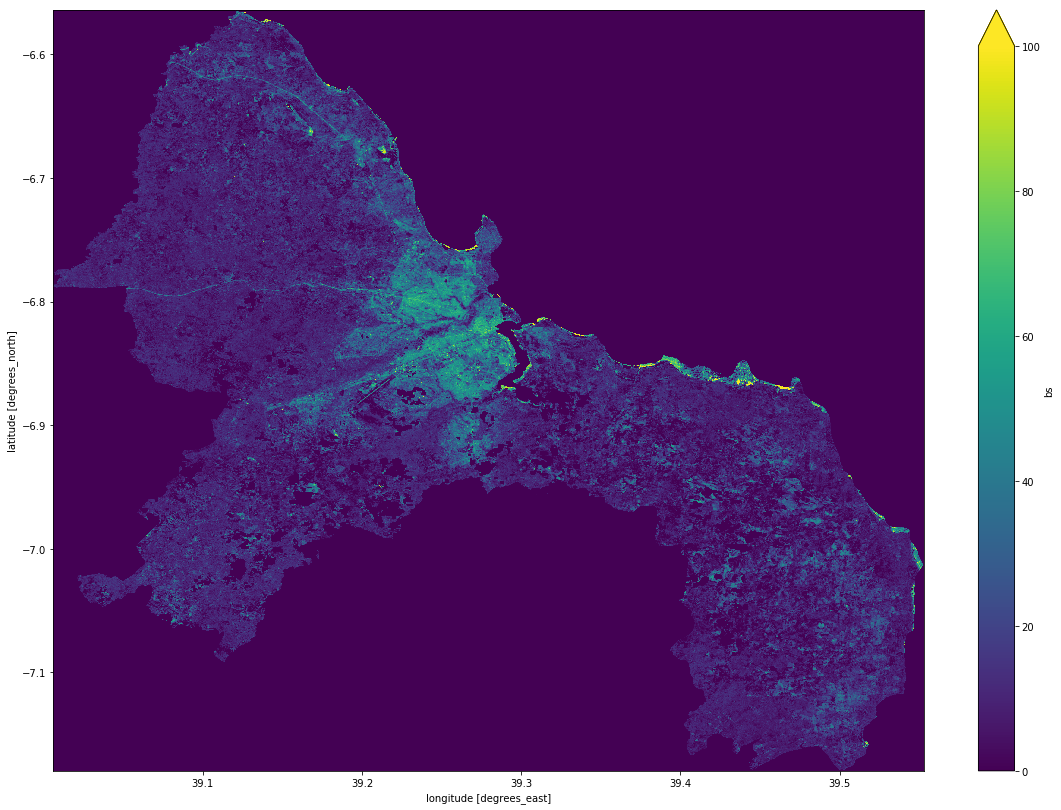

In [37]:
plt.figure(figsize = (19.5, 14))
urban_composite_t1.plot(**plot_kwargs)
plt.show()

> ### **Last Year Urban Composite**

In [38]:
urban_composite_t2 = urban_index_func(filtered_composite_t2)

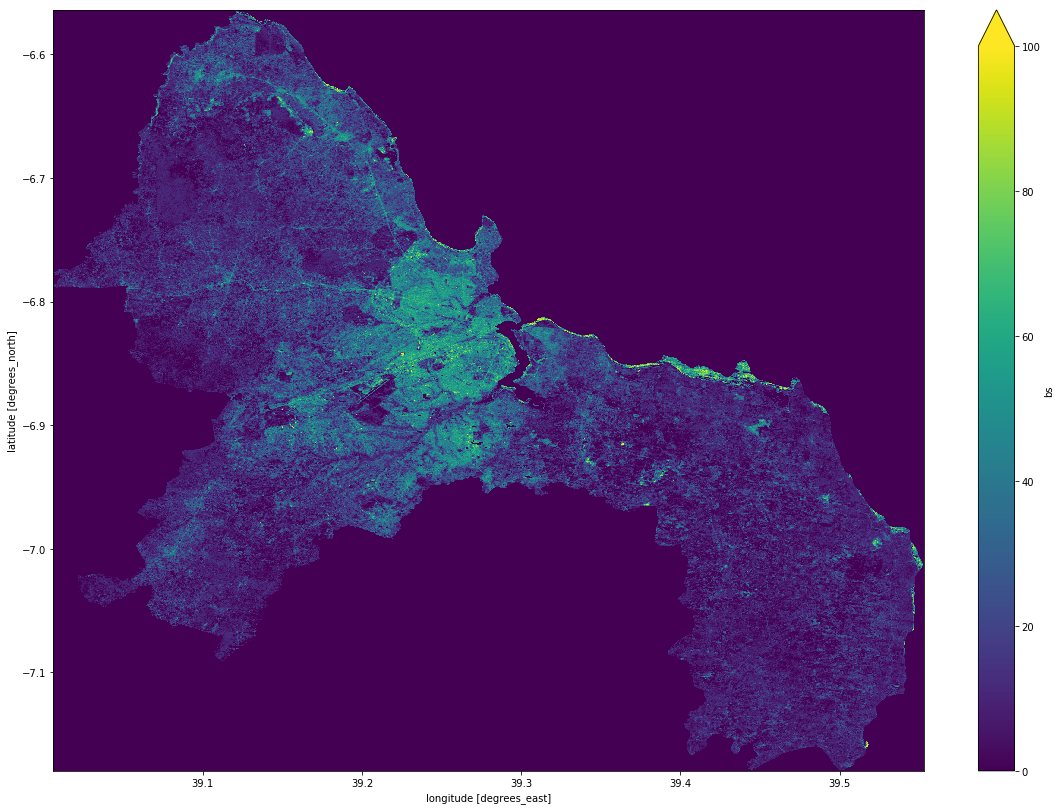

In [39]:
plt.figure(figsize = (19.5, 14))
urban_composite_t2.plot(**plot_kwargs)
plt.show()

> ### Defining Binary Urbanization

In [40]:
def urbanizaton(urban_index: xr.Dataset, urbanization_index) -> xr.DataArray:
    bounds = None
    if urbanization_index == 'NDBI':
        bounds = (0,0.3)
    if urbanization_index == 'Fractional Cover Bare Soil':
        bounds = (25, 100)
    
    urban = np.logical_and(urban_index > min(bounds), urban_index < max(bounds))
    
    is_clean = np.isfinite(urban_index)
    urban = urban.where(is_clean)
    
    return urban

In [41]:
urban_product_t1 = urbanizaton(urban_composite_t1, urbanization_index)
urban_product_t2 = urbanizaton(urban_composite_t2, urbanization_index)

> ### First Year
> Urbanization product overlayed on false color composite 

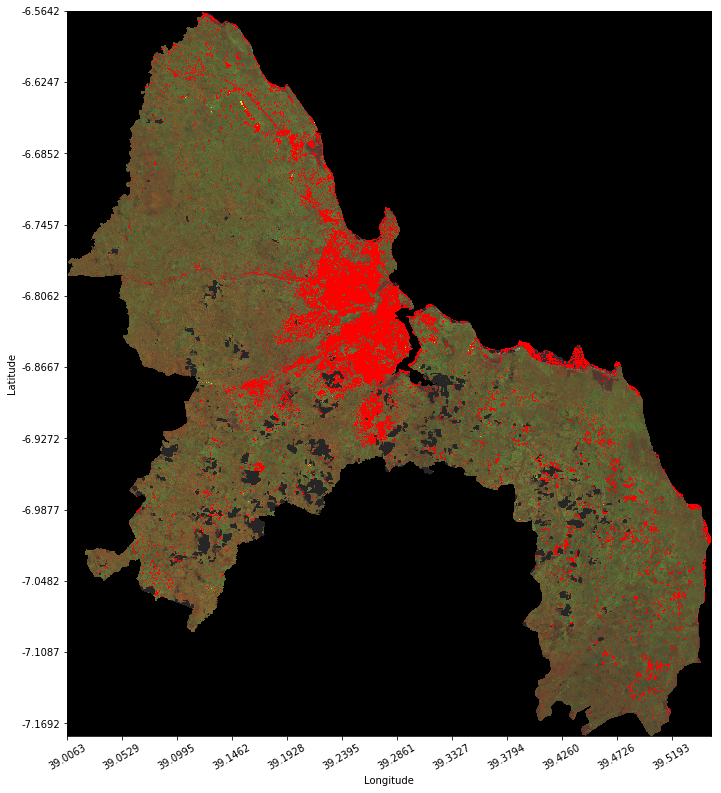

In [42]:
rgb(filtered_composite_t1, 
           bands = ["nir","swir1","blue"], 
           paint_on_mask = [(np.logical_and(urban_product_t1.astype(bool), mask), [255,0,0])],
           width = 15)
plt.show()

> ### Last Year
> Urbanization Product overlayed on false color composite 

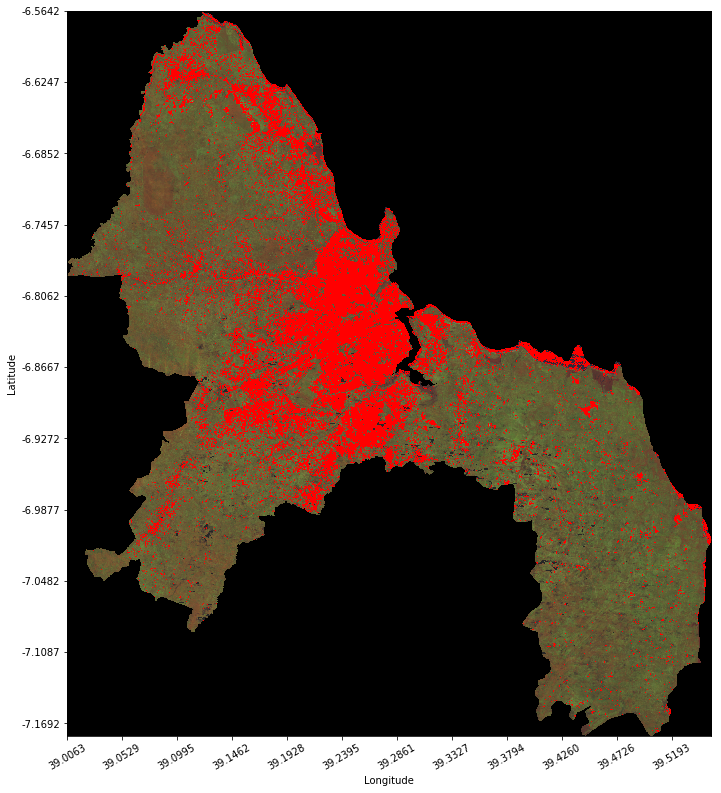

In [43]:
rgb(filtered_composite_t2,
    bands = ["nir","swir1","blue"],
    paint_on_mask = [(np.logical_and(urban_product_t2.astype(bool), mask),[255,0,0])],
    width = 15)
plt.show()

> ### Urbanization Change

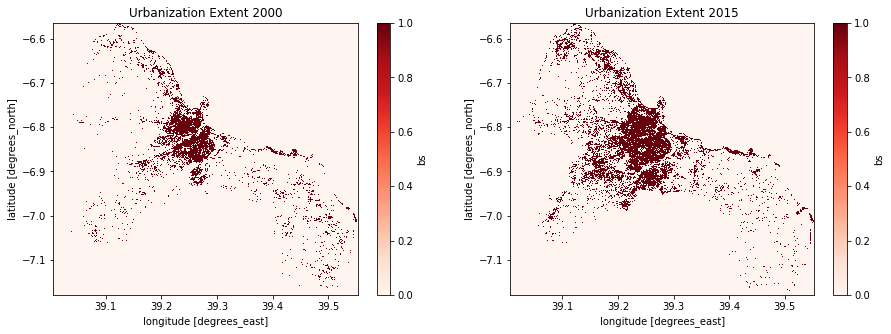

In [44]:
fig = plt.figure(figsize = (15,5))

#T1 (LEFT)
ax1 = fig.add_subplot(121)
urban_product_t1.plot(cmap = "Reds")
ax1.set_title("Urbanization Extent {}".format(first_year))

#T2 (RIGHT)
ax2 = fig.add_subplot(122)
urban_product_t2.plot(cmap = "Reds")
ax2.set_title("Urbanization Extent {}".format(last_year))

plt.show()

In [45]:
urbanized_area_t1 = float(  urban_product_t1.sum()  )
urbanized_area_t2 = float(  urban_product_t2.sum()  )

In [46]:
consumption_rate = land_consumption_rate(area_t1 = urbanized_area_t1, area_t2 = urbanized_area_t2, y = 10)

In [47]:
print("Land Consumption Rate of the Survey Region: {:.2%}".format(consumption_rate))

Land Consumption Rate of the Survey Region: 6.16%


## <a id="indicator"></a>SDG Indicator 11.3.1 [&#9652;](#top)

In [48]:
print("The UN SDG 11.3.1 Indicator value (ratio of land consumption rate to population growth rate) "\
      "for this survey region is {:.2%}.".format(sdg_11_3_1(consumption_rate,pop_growth)))

The UN SDG 11.3.1 Indicator value (ratio of land consumption rate to population growth rate) for this survey region is 100.13%.
